In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator,DayLocator, MONDAY
from mpl_finance import  candlestick_ohlc
import time
from IPython import display

#,quotes_historical_yahoo
#print(dir(mpl_finance))
#MAIN SYMBOL CLASS HOLD ALL SYMBOL RATES

class CSymbol():                
    '''The CSymbol class contains and save quotes for each instrument and do a pandas index by time'''
    
    def __init__(self,specs={}):                
        #get symbols specifications like swaps min volum max volum symbol name precision contract volum etc..
        self.specs=specs            
        self.rates=pd.read_csv(specs["file_name"],sep="\t") 
        
        ##DELETE THIS SECTION
        #this just for debug i forced delete some items to reproduce syncronization issues
        if specs["symbol_name"]=="GBPUSD":
            self.rates.drop(0,inplace=True)
            
        if specs["symbol_name"]=="USDJPY":
            self.rates.drop(2,inplace=True)
            
        if specs["symbol_name"]=="EURUSD":
            self.rates.drop(3,inplace=True)            
        ###END DELETE
        
        self.rates.columns=specs["symbol_name"]+self.rates.columns        
        self.rates = self.rates.rename(columns={(specs['symbol_name']+"Datetime"):"time"})                
        self.rates.set_index("time",inplace=True)
        
        return None
    
    #TODO if we whant a live reader enviroment 
    def get_from_peer():
        return None
    def recived_from_peer():
        return None


    
####CLASS CSimulator    
class CSimulator:    
    '''This is the main class of development aims to keep the enviorement updated
    (Stadistics, Open Operations, History, Manage Strategy Operations, and Update Indicator calculations).'''
    def __init__(self,enviroment,i_symbols=[],indicators=[],inital_step=0):        
        self.Symbols=[] 
        self.Indicators=indicators #list of indicators each perform method calculate current_state
        self.PosInfo=[]#list of active positions
        self.PosHist=[]#history all closed positions
        self.StatsHist=[]#history all stats
        self.Strategys=[]
        self.enviroment=enviroment
        #basic stats
        self.initial_balance=enviroment["balance"]
        self.current_balance=self.initial_balance
        self.current_equity=self.initial_balance
        #TODO max min equity balance max min equi balanc drwadown etc..
        
        for x in i_symbols:
            newsym=CSymbol(x)
            self.Symbols.append(newsym)
            
        
        self.syncronize_symbols()#syncronize all symbols indexs
        self.set_cursor(inital_step)#init cursos at step 0
        return None
    def add_strategy(self,strategy):
        '''Once you initialited your simulator you can add many strategy you need on you simulator'''
        self.Strategys.append(strategy)
        return None
    #Syncronize all symbols datetimes by key time
    def syncronize_symbols(self):
        '''First of all we need sicronize all timeseries at same initial step and mach
        future index'''
        newindex=""
        for x in range(len(self.Symbols)-1):
            newindex= self.Symbols[x].rates.index.union(self.Symbols[x+1].rates.index)

        for x in range(len(self.Symbols)):
            self.Symbols[x].rates=self.Symbols[x].rates.reindex(newindex)
            
        for x in range(len(self.Symbols)):            
            self.Symbols[x].rates.fillna(method='ffill',inplace=True)
           
        
        #once we filled all na values with previous value only na values apear if first time step is na
        #we delete this time step and previus for all time series
        natimes=[]
        for x in range(len(self.Symbols)):
            natimes.append(self.Symbols[x].rates[self.Symbols[x].rates.isnull().any(axis=1)].index.tolist() )
                
        
        maxtimevalid=max(natimes)[0]
        #remove initial invalid times to sicronize all symbols at same time
        for x in range(len(self.Symbols)):
            tmp=self.Symbols[x].rates.reset_index()
            self.Symbols[x].rates=tmp[tmp["time"]>maxtimevalid]
            self.Symbols[x].rates.set_index("time",inplace=True)
                
        return None
    
    def plotSimulator(self,rates=False,indicators=False,Stats=False,ActiveOrders=False,HistoricOrders=False):
        display.clear_output(wait=True)
        '''Manage Plot actions'''
        if rates:
            self.plot_rates()
            
        if indicators:
            self.plot_indicators()
            
        #TODO plot historic order
        #TODO plot Active Orders
        #TODO plot actual stats
        return None
    def plot_indicators(self):
        '''Plot Indicator, please pay attention to Indicator classed each indicator need implement a plot method'''
        MAXCOLUMNS=2
        rows=int(len(self.Indicators)/MAXCOLUMNS)
        if rows<len(self.Indicators)/MAXCOLUMNS:
            rows+=1
       
        #adebug quotes format        
        
        fig, ax = plt.subplots(rows,MAXCOLUMNS,figsize=(13,13))
        fig.subplots_adjust(bottom=0.2)
        idx=0
        for x in range(rows):
            for y in range(MAXCOLUMNS):           
                if idx<len(self.Indicators):
                    self.Indicators[idx].plot(ax[x][y]) #send axis to Indicator each indicator plot their buffers...
                idx+=1    
                    
        display.display(plt.show())            
        return None
    def plot_rates(self):
        '''Ploting all symbols rates until current state mpl_finance library used'''
        #for each symbol on Symbols plot until cursor
        mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
        alldays = DayLocator()              # minor ticks on the days
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        dayFormatter = DateFormatter('%d')      # e.g., 12
        MAXCOLUMNS=2
        rows=int(len(self.Symbols)/MAXCOLUMNS)
        if rows<len(self.Symbols)/MAXCOLUMNS:
            rows+=1
       
        fig, ax = plt.subplots(rows,MAXCOLUMNS,figsize=(13,13))
        fig.subplots_adjust(bottom=0.2)
        idx=0
        for x in range(rows):
            for y in range(MAXCOLUMNS):           
                if idx<len(self.Symbols):
                    ax[x][y].xaxis.set_major_locator(mondays)
                    ax[x][y].xaxis.set_minor_locator(alldays)
                    ax[x][y].xaxis.set_major_formatter(weekFormatter)
        #ax.xaxis.set_minor_formatter(dayFormatter)
                
        
                    tmp=self.Symbols[idx].rates.reset_index()
        
                    quotes= [tuple([tmp["time"][i],
                             tmp[self.Symbols[idx].specs["symbol_name"]+"Open"][i],
                             tmp[self.Symbols[idx].specs["symbol_name"]+"High"][i],
                             tmp[self.Symbols[idx].specs["symbol_name"]+"Low"][i],
                             tmp[self.Symbols[idx].specs["symbol_name"]+"Close"][i]]) 
                                             for i in range(len(self.Symbols[idx].rates[0:self.current_step]))] 
                
        #time, open, high, low, close, …
                    candlestick_ohlc(ax[x][y], quotes, width=0.6)
        
                    ax[x][y].xaxis_date()
                    ax[x][y].autoscale_view()
                idx+=1
                
        
        plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
        display.display(plt.show())
        return None
    
    def set_cursor(self,step=0):
        '''For interactive session in Turn method we move cursor'''
        self.current_step=step        
        return None
    
    
    def Turn(self):
        '''Main method on simulator class
        return True if we have more timeseries to proces
        call method calculation for each indicator
        call method run_strategy for each strategy and perform operation if any
        TODO perform Stadistical calculations at each step'''
        if self.current_step<len(self.Symbols[0].rates):                
            #calculate all buffers
            for x in range(len(self.Indicators)):
                self.Indicators[x].calculation(self.current_step,self.Symbols)
            
            
            #once new state calculated run all strategys in stack nd perform operations
            for x in range(len(self.Strategys)):
                ops_array=self.Strategys[x].run_strategy(self)
                for operation in ops_array:
                    Perform_OPS(operation)
                
            self.calcSates()
            self.set_cursor(self.current_step+1)
            
            return True
        return False
    
    def getRatesHist(self):
        '''
        return1 rates as pandas tabular joined table
        return2 rates as list
        return3 all indicators buffer
        ALL RETURNS ONLY UNTIL CURRENT_STEP of simulation
        '''
        ret=pd.DataFrame()
        rates_list=[]
        indicators_list=[]
        #return rates in joined pandas and list of pandas for easy processing latter
        for x in range(len(self.Symbols)):
            ret=pd.concat((ret,self.Symbols[x].rates[0:self.current_step]),axis=1)
            rates_list.append(self.Symbols[x].rates[0:self.current_step])
            
        #return all indicators buffers in list of bufer with shape(steps_procesed,buffer_len)
        for x in range(len(self.Indicators)):
            indicators_list.append(self.Indicators[x].buffer)
        return ret,rates_list,indicators_list
    
    
    def Perform_OPS(self,operation):
        '''TODO perform operation pased on operation open close positions etc...'''
        return None
    #return n pandas frames with all Symbols sycronizeds
    
    #return current stadisitical opbjects
    def getStats(self):
        '''TODO return current Stadistics'''
        return None
    
    #return all current stadistical object from step 0 to current state
    def getStatsHistory(self):
        '''TODO return historical Stadistics'''
        return None
        
    def calcSates(self):
        '''TODO called from Turn Mehtod update current Stadistics'''
        return None
        
    def PositionsCount(self,strategy_id):
        '''TODO helping method used on Strategy classes'''
        #if strategy_id empty return all positions
        #if not retounr positions to related strategy
        return 0    
    
###YOU CAN DEFINE YOUR CUSTOM INDICATORS 
###EACH INDICATOR need 3 mandatory fields
##########-Buffers -->number of buffers
##########-Buffer -->numpy array with shape (current_step,Buffers)
##########-interalsteps -->manage incremental step
###EACH INDICAATOR need 2 mandatory methods called in class CSimulator
##########-calculation -->perform indicator calculations for current state
##########-plot        -->plot indicator buffers 


class CCustomIndicatorMA():
    '''Basic MA indicator, applied to price close you improve them...'''
    def __init__(self,name="IndicatorName",specs={}):        
        self.name=name
        self.specs=specs
        self.buffers=1#this indicator implement only one bufer
        self.EMPTY_VALUE=1
        self.buffer=np.empty((0,1))
        #np.zeros((1,self.buffers)) #prepare numpy arry with shape(size initial 1, buffer_size)
        
        self.internalsteps=0
        return None
    def calculation(self,step,symbols=[]):
        #CUSTOM CALCULATION FOR INDICATOR calculation method called from simulator.Turn()
        #info this indicator perform a basic MA calculation at price close        
        self.internalsteps+=1        
        self.buffer=np.resize(self.buffer,(self.internalsteps,self.buffers))                
        
        rates=None
        symbol=None
        for x in symbols:
            if x.specs["symbol_name"]==self.specs["symbol"]:
                rates=x.rates                    
                break
                    
        if self.internalsteps>self.specs["period"]:
            #if we can calculate indicator we done            
            #we symbol by symbol_name of this indicator
            
            self.buffer[self.internalsteps-1,0]=np.sum(rates[self.specs["symbol"]+"Close"][step-self.specs["period"]:step])/self.specs["period"]            
        else:
            #we can set as EMPTY_VALUE or set last price just for ploting issue
            self.buffer[self.internalsteps-1,0]=rates[self.specs["symbol"]+"Close"].values[step]
                    
        return None
 
    def plot(self,ax):
        ax.plot(self.buffer)
        return None
    
    
#example maoscilator reusing MAIndicator calculations    
class CCustomIndicatorMAOscilator():
    '''Example resuing code for CCustomIndicatorMA in this case we divide fast / slow MA Indicators
    to perform a classical oscilator indicator'''
    def __init__(self,name="IndicatorName",specs={}):        
        self.name=name
        self.specs=specs
        self.buffers=1#this indicator implement only one bufer         
        
        self.subind_fast=CCustomIndicatorMA("temp0",{"symbol":specs["symbol"],"period":specs["period_fast"]})
        self.subind_slow=CCustomIndicatorMA("temp0",{"symbol":specs["symbol"],"period":specs["period_slow"]})        
        self.EMPTY_VALUE=1
        self.buffer=np.empty((0,1))
        #np.zeros((1,self.buffers)) #prepare numpy arry with shape(size initial 1, buffer_size)
        #self.buffer[0,0]=self.EMPTY_VALUE
        self.internalsteps=0
        return None
    
    def calculation(self,step,symbols=[]):   
        #calculate intermediate buffers first
        self.subind_fast.calculation(step,symbols)
        self.subind_slow.calculation(step,symbols)
        
        self.internalsteps+=1
        self.buffer=np.resize(self.buffer,(self.internalsteps,self.buffers))
        if self.internalsteps>self.specs["period_slow"]:
            #if we can calculate indicator we done            
            
            self.buffer[self.internalsteps-1,0]=self.subind_fast.buffer[self.internalsteps-1]/self.subind_slow.buffer[self.internalsteps-1]
            
        else:
            self.buffer[self.internalsteps-1,0]=self.EMPTY_VALUE
                    
        return None
    
    def plot(self,ax):        
        ax.plot(self.buffer)
        return None
        

class CCustomIndicatorMultiMAOscilator():
    '''Another example for reusing code in this case we reuse Oscilator Indicator to perform a new indicator
    with 3 buffers at same time'''
    def __init__(self,name="Multioutputs",specs={}):
        self.name=name
        self.specs=specs
        self.EMPTY_VALUE=1
        
        self.buffers=specs["num_outs"]
        self.buffer=np.empty((0,self.buffers))
        #np.zeros((1,self.buffers)) #prepare numpy arry with shape(size initial 1, buffer_size)
        
        self.sub_ind_buf=[]
        for x in range(self.buffers):            
            self.sub_ind_buf.append(CCustomIndicatorMAOscilator("tmp", {"symbol":specs["symbol_"+str(x)],"period_fast":specs["period_fast"],"period_slow":specs["period_slow"]} ))
           # self.buffer[0,x]=self.EMPTY_VALUE                    
        
        self.internalsteps=0            
        return None
    def calculation(self,step,symbols=[]):
        self.internalsteps+=1
        self.buffer=np.resize(self.buffer,(self.internalsteps,self.buffers))
        #calculate intermediate indicators buffers first
        for x in range(self.buffers):
            self.sub_ind_buf[x].calculation(step,symbols)
            
        if self.internalsteps>self.specs["period_slow"]:
            #if we can calculate indicator we done            
            for x in range(self.buffers):                
                self.buffer[self.internalsteps-1,x]=self.sub_ind_buf[x].buffer[self.internalsteps-1]
                
          # print(self.buffer[self.internalsteps])
        else:
            for x in range(self.buffers):
                self.buffer[self.internalsteps-1,x]=self.EMPTY_VALUE
            
        return None
    
    def plot(self,ax):
        palette=[]
        palette.append("green")
        palette.append("red")
        palette.append("blue")
        for x in range(self.buffers):
            ax.plot(self.buffer[:-1,x],color=palette[x])
        
        return None


    
class COptimizer():
    '''TODO we can optimize strategy class by running on simulator multiple times
    -Full-->Perform a full optimization for each param
    -Genetics-->Perform a genetic optimization
    -SA-->Perform a simulated annealing optimization
    ###PERFORM OPERATIONS IN PARALEL '''
    def __init__(self,simulator,strategy,optimizer_type,metric,params):
        return None
    def run_optimization(self):
        return None
    def get_best_params(self):
        return None
    

class CTrade():
    '''Save new operations information this class is processed on CSimulator'''
    def __init__(self,tiket=-1,op_type=-1,symbol_id=-1,volum=-1,strategy_id=""):
        self.tiket=tiket
        self.type=op_type
        self.symbol_id=symbol_id
        self.volum=volum
        self.strategy_id=strategy_id
        return None
    
#HELP POSITIONINFO     
class CPositionInfo():
    '''TODO save position info...'''
    
    def __init__(self,volumn,xtype,symbol,step_open):
        self.volumn=0.
        self.type=-1 #0 short  1 long
        self.symbol = None#class symbol
        self.step_open =None#step open price
        self.step_close = None #none or step to close price
        self.current_profit = 0. #positive or nevative profit
        self.tiket=-1
        self.strategy_id=-1
        return None
    
    


In [7]:

def main():    
    ##ADD SYMBOLS DATA AND SPECIFICATIONS 
    all_symbols=[]
    specs={"file_name":'data/EURUSD0.csv',
           "symbol_name":"EURUSD",
           "precision":5,
           "swap_long":-0.8,
           "swap_short":-0.4,
           "contract_volum":100000}
    all_symbols.append(specs)
    
    specs={"file_name":'data/GBPUSD0.csv',
           "symbol_name":"GBPUSD",
           "precision":5,
           "swap_long":-0.8,
           "swap_short":-0.4,
           "contract_volum":100000}
            
    
    all_symbols.append(specs)
    
    specs={"file_name":'data/USDJPY0.csv',
           "symbol_name":"USDJPY",
           "precision":3,
           "swap_long":-0.8,
           "swap_short":-0.4,
           "contract_volum":100000}
    
    all_symbols.append(specs)
    
    
    #ADD INDICATORS TO SIMULATOR
    indicator_list=[]
        
    #Simple MA Indicator for EURUSD
    specs={"symbol":"EURUSD","period":5}
    eurusd_ma_fast=CCustomIndicatorMA("EURUSD_Fast_ma",specs)
    
    
    #Simple MA Indicator for GBPUSD
    specs={"symbol":"GBPUSD","period":5}
    gbpusd_ma_fast=CCustomIndicatorMA("GBPUSD_Fast_ma",specs)
    
    #Simple MA Indicator for USDJPY
    specs={"symbol":"USDJPY","period":15}
    usdjpy_ma_slow=CCustomIndicatorMA("USDJPY_Slow_ma",specs)
    
    
    #MA Osciliator example reusing code for MA Indicator
    specs={"symbol":"EURUSD","period_fast":5,"period_slow":15}    
    eurusd_oscilator=CCustomIndicatorMAOscilator("MAOscilator",specs)
        

    #Multiple outputs or multi symbol indicator reusing MAOscilator
    specs={"num_outs":3,"symbol_0":"EURUSD","symbol_1":"USDJPY","symbol_2":"GBPUSD",
             "period_fast":5,"period_slow":15}
    multisymbol_multiouputs=CCustomIndicatorMultiMAOscilator("Multioutputs",specs)
        
    #MA
    indicator_list.append(eurusd_ma_fast)
    indicator_list.append(gbpusd_ma_fast)
    indicator_list.append(usdjpy_ma_slow)
    
    #MA oscilator
    indicator_list.append(eurusd_oscilator)
    
    #Multi outputs
    indicator_list.append(multisymbol_multiouputs)
    
    
    #DEFINE INITIAL ENVIROMENT FOR SIMULATOR
    initial_step=0
    enviroment={
                "balance":10000,
                "leverage":30
               }
    
    
    #We have symbols information / indicators / enviroment we can create a simulator
    simulator=CSimulator(enviroment,all_symbols,indicator_list,initial_step)
    
    
    
    #EXAMPLE USAGE 1 Simple rates + indicators ploting
    while simulator.Turn():
        simulator.plotSimulator(rates=True,indicators=True,Stats=False,ActiveOrders=False,HistoricOrders=False)
        time.sleep(0.2)
        
        
    #EXAMPLE USAGE2 2, create you Custom Strategy and send to simulator
    class CStrategyMA():    
        '''Each Strategy can be passed to simulator by method add_strategy
        each class need a mandatory field strategy_id as a unique identifier for all Strategys
        each class need implement run_strategy(self,simulator) this method is called in CSimulator.Turn()
        run_strategy return a list of CTrade operations to do
        '''
        def __init__(self,name,strategy_id,indicators=[],symbols=[]):
        #recibe all inputs parameter needed on run_strategy
            self.name=name      
            self.strategy_id            
            self.indicators=indicators
            self.symbols=symbols
            return None
    
        def run_strategy(self,simulator):    
            Operations=[]
            #check if we need close positions first
            for x in range(self.simulator.PositionsCount("")):
                if (simulator.PosInfo[x].strategy_id==self.strategy_id) & (simulator.PosInfo[x].type == 0) & (simulator.Indicators[self.indicators[0]].getbuffer()[0]>simulator.getClose(self.symbols[0])):
                        op=CTrade(tiket=simulator.PosInfo[x].tiket)
                        operations.append(op)                        
                if (simulator.PosInfo[x].strategy_id==self.strategy_id) & (simulator.PosInfo[x].type == 1) & (simulator.Indicators[self.indicators[0]].getbuffer()[0]<simulator.getClose(self.symbols[0])):                    
                        op=CTrade(tiket=simulator.PosInfo[x].tiket)
                        operations.append(op)                        
                        
            #check  if we need open
            if simulator.PositionsCount(self.strategy_id)==0:
                if simulator.Indicators[self.indicators[0]].getbuffer()[0]>simulator.getClose(self.symbols[0]):                    
                    op=CTrade(tiket=-1,op_type=0,symbol=self.symbols[0],volum=0.01,strategy_id=self.strategy_id)
                    operations.append(op)
                if simulator.Indicators[self.indicators[0]].getbuffer()[0]<simulator.getClose(self.symbols[0]):                        
                    op=CTrade(tiket=-1,op_type=1,symbol=self.symbols[0],volum=0.01,strategy_id=self.strategy_id)
                    operations.append(op)
                    
            return Operations
    
    trade_ind=[]
    trade_ind.append(0) #perform trades based on indicator 0 on simulator
    trade_sym=[]
    trade_sym.append(0) #perform trades based on symbol 0 on simulator
    strategy1=CStrategyMA("Basic MA crossing strategy EURUSD","magicnumber12345",trade_ind,trade_sym)
    
    trade_ind=[]
    trade_ind.append(1) #perform trades based on indicator 1 on simulator
    trade_sym=[]
    trade_sym.append(1) #perform trades based on symbol 1 on simulator
    strategy2=CStrategyMA("Basic MA crossing strategy GBPUSD","magicnumber54321",trade_ind,trade_sym)
    
    simulator=CSimulator(enviroment,all_symbols,indicator_list,initial_step)
    #we can add one or multiple strategys
    simulator.add_strategy(strategy1)
    simulator.add_strategy(strategy2)
    
    while simulator.Turn():
        simulator.plotSimulator(rates=False,indicators=False,Stats=True,ActiveOrders=True,HistoricOrders=False)
        time.sleep(0.2)
        
    #EXAMPLE USAGE 3 optimization strategy
    #optimization methods could be "Full, Genetics, SA"
    #metrics are implemented on simulator chose one
    optimization="Genetics"
    metric="BalanceMAX"
    #optimization params syntaxis [IND_ID]_[param_name]_[init/steps/end]
    params={"0_period_init":3,
            "0_period_step":1,
            "0_period_end":24}
    
    
    
    optimizer=COptimizer(simulator,strategy1,optimization,metric,params)
    optimizer.run_optimization()
    
    #once optimization end we can run strategy with best prams
    one_indicator_list=[]            
    specs={"symbol":"EURUSD","period":optimizer.get_best_params()[0]}
    eurusd_ma_fast=CCustomIndicatorMA("EURUSD_Fast_ma",specs)    
    one_indicator_list.append(eurusd_ma_fast)
    trade_ind=[]
    trade_ind.append(0)
    trade_sym=[]
    trade_sym.append(0)
    
    strategy1=CStrategyMA("Basic MA crossing strategy EURUSD","magicnumber12345",trade_ind,trade_sym)    
    
    simulator=CSimulator(enviroment,all_symbols,one_indicator_list,initial_step)    
    
    simulator.add_strategy(strategy1)
    
    while simulator.Turn():
        simulator.plotSimulator(rates=False,indicators=False,Stats=True,ActiveOrders=True,HistoricOrders=True)
        time.sleep(0.2)
    
    
    
    #EXAMPLE USAGE 4 - Classic Machine Learning Modeling / DeepLearning or Q-lerning to predict next timeseries value
    #run simulator over 80% dataset
    
    simulator=CSimulator(enviroment,all_symbols,indicator_list,initial_step)    
    
    size=len(simulator.Symbols[0].rates)
    train_size=int(size*0.8)
    test_size=size-train_size
    for x in range(train_size):
        simulator.Turn() 
    
    #Method getRatesHist return return rates from step 0 to current state(in tabular and list mode) also return all indicator values
    X_train_tabular,X_list_mode,X_indicator_vals=simulator.getRatesHist() 
    print(x_train.shape,len(list_mode),len(indicator_vals))
    print(list_mode[0].shape)
    print(indicator_vals[4].shape)
    ####Preproces your data with prefered window method
    ####Perform you favourite ML or DL models
    ####Once learned you model we can create a custom strategy
    model="model"#just a demo do your model with predict method...
    class CStrategyModel():
        '''Same as basic Strategy plus we can send a model and use them on run_strategy method'''
        def __init__(self,name,strategy_id,trade_ind,trade_sym,model):
            self.name=name     
            self.strategy_id            
            self.indicators=indicators
            self.symbols=symbols
            return None
        def run_strategy(self,simulator):
            Operations=[]
            X_train_tabular,X_list_mode,X_indicator_vals=simulator.getRatesHist() 
            #prepoces YOURDATA again for you model
            
            pred_values=model.predict(YOURDATA)
            #Perform you operations based on pred_valus
            #for i,pred in enumerate(pred_values):
               # if pred>0:#buy
                    #add your operation
               # if pred<0:#sell
                    #add you operation
            return Operations
    
    trade_ind=[0,1,2,4,5] #trade with 5 indicator valus
    trade_sym=[0,1,2] #trade with 3 symbols
    model_strategy=CStrategyModel("Trade with Model","magic9999999",trade_ind,trade_sym,model)
    simulator.add_strategy(model_strategy)
    
    #Check you strategy model with samples out the training data
    for  x in range(len(test_size)):
        simulator.Turn()
        simulator.plotSimulator(rates=False,indicators=False,Stats=True,ActiveOrders=True,HistoricOrders=True)
        time.sleep(0.2)
    
    
    #EXAMPLE USAGE 5 in DeepLearning genetic weigth optimization or NEAT
    #Check in this case we don't use deeplearning to predict next values on time series
    #we use deeplearning to take a descion based on previous desicions
    #the netowrk recibe the simulator enviorment (this is active order and historic order NOT INDICATOR VALUES)
    #for x in range(generations):
    #   run_specie_in_parallel(CStrategy strategy(simulator,species_genes)):
    #   wait until_all_species_end
    #   mutate_crossover_evolve
    #
    #Finaly we can test with best network strategy(best_genes).run
            
        
    #EXAMPLE USAGE 6 with deep q-learning similar to NEAT we try NOT TO USE INDICATOR VALUES
    #qlearnig recibe enviroment stats
    #while continue_train==True:
    #   simulator.reinit_state(0)
    #   while simulator.Turn():
    #      enviroment=simulator.get_enviroment()
    #      actions=qlearning(enviroment)
    #      simulator.perform(actions)
    #      rewards=get_rewards(simulator.stats())
    #      
    
    
    
    


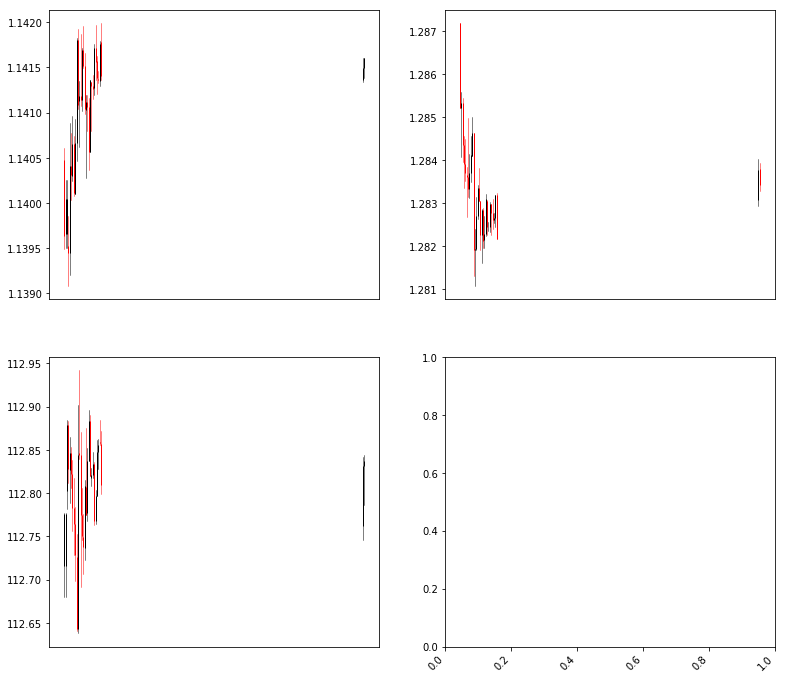

None

KeyboardInterrupt: 

In [9]:
main()
